## 6-8. 프로젝트 : 모든 장르 간 편향성 측정해 보기
지금까지 우리는 영화 시놉시스 코퍼스를 가지고 영화 구분과 영화 장르 간에 내재된 편향성을 측정하는 작업을 진행해 보았습니다. 어느 정도는 우리의 상식과 일치하는 편향성이 측정되었을 것입니다.

이번에는 모든 장르에 대해 영화 구분과의 편향성 정도를 측정해 보겠습니다. 대부분의 과정은 이전 스텝에서 이미 진행한 내용을 참고해서 동일하게 진행 가능할 것입니다.

#### 라이브러리 버전을 확인해 봅니다
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


#### STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

**(1) 데이터 로드**

In [2]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

**(2) 형태소 분석 및  명사만 추출**

In [3]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

슝~


In [4]:
print(len(tokenized))
print(tokenized[:5])

71156
[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'], ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'], ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를'], ['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행'], ['두', '사람', '날', '은수', '아파트', '밤']]


#### STEP 2. 추출된 결과로 embedding model 만들기

**(1) tokenized에 담긴 데이터로 word2vec embedding model 생성**


**[참고]**
* Word2Vec model은 문자 Sentence를 단어 토큰화해서, 정수 인덱싱없이 Sentence 상태로 입력함    
   - model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)     
* Word2Vec model은 보통은 별도로 train() 메소드없이 학습되는데, 학습하다중간에 저장했을 경우,다시 load하여,train시킬때, model.train(Sentence, total_examples=1, epochs=1)와 같이 학습시킴, 보통은 train 메소드없이 학습이 되는 것으로 보임

* pre_trained(사전학습)된 모델을 불러오려면, KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)으로 함




In [5]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('작품', 0.8790116906166077),
 ('다큐멘터리', 0.829826831817627),
 ('드라마', 0.8221210241317749),
 ('형식', 0.7861706614494324),
 ('영화로', 0.784394383430481),
 ('주제', 0.7733771204948425),
 ('코미디', 0.7713078260421753),
 ('감동', 0.7686890959739685),
 ('버자이너', 0.7481526136398315),
 ('설정', 0.7462124824523926)]

In [6]:
#print(dir(model.wv))
#print(model.wv.vocab)
print(len(model.wv.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(model.wv['영화']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(model.wv.vectors.shape)

24320
100
(24320, 100)


In [7]:
model.wv.most_similar(positive=['사랑'])

[('아르튬', 0.7157703042030334),
 ('애정', 0.7130234241485596),
 ('행복', 0.7019501328468323),
 ('첫사랑', 0.6940522789955139),
 ('연애관', 0.6881079077720642),
 ('이별', 0.6794293522834778),
 ('진심', 0.6789792776107788),
 ('만남', 0.6786412000656128),
 ('연애', 0.6668484807014465),
 ('용기', 0.6647398471832275)]

In [8]:
model.wv.most_similar(positive=['연극'])

[('영화감독', 0.9146103262901306),
 ('시나리오', 0.8748674988746643),
 ('오페라', 0.87274569272995),
 ('예술가', 0.8712066411972046),
 ('캐스팅', 0.8698539733886719),
 ('영감', 0.8689728379249573),
 ('배우', 0.8676545023918152),
 ('데뷔', 0.8626595139503479),
 ('예술', 0.862272322177887),
 ('각색', 0.8620381951332092)]

**(2) TF-IDF로 단어 셋만들기**

In [9]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)


In [10]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [11]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [12]:
print(X[:,:5],X[0].shape)
print("dense",X[0].todense()[:5],len(X[0].todense()[0]))
print("tocco","col",X[0].tocoo().col,"data",X[0].tocoo().data, len(X[0].tocoo().col),len(X[0].tocoo().data))
#print("model.wv",[x for x in model.wv])
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

  (0, 1)	0.0003626867654624366
  (0, 3)	0.0003626867654624366
  (0, 4)	0.016683591211272084
  (1, 2)	5.3486686185153744e-05
  (1, 0)	0.001497627213184305
  (1, 1)	7.611243548713899e-05
  (1, 3)	0.00034250595969212547
  (1, 4)	0.019941458097630416 (1, 41082)
dense [[0.         0.00036269 0.         ... 0.         0.00025487 0.        ]] 1
tocco col [24288 30456 11824 ... 16979 23276 16393] data [0.00018134 0.00018134 0.00025487 ... 0.00398955 0.00072537 0.00253881] 18995 18995
23976
영화


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)] # col: 단어인덱스  18955개, data: tfidf 값 18955개
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
print(len(w1), len(w2))

art_word100= []
gen_word100= []
print('예술영화를 대표하는 단어들:')
for i in range(100):
    artword = vectorizer.get_feature_names()[w1[i][0]]    
    print(artword, end=', ')
    art_word100.append(artword)
#print("art_word100", art_word100)       
print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    genword = vectorizer.get_feature_names()[w2[i][0]]    
    print(genword, end=', ')
    gen_word100.append(genword   )
#print("gen_word100", gen_word100) 


18995 37717
예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

**(3) 중복단어 제거후 대표성있는 단어 15개 선정**

In [14]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 있는대로 모두 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): 
        target_art.append(w1_[i])
    
# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 1는대로 모두추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): 
        target_gen.append(w2_[i])
        
#중복 단어수 산정 
print(len(target_art), len(target_gen))  
same_word_num1 = 100 - len(target_art)
same_word_num2 = 100 - len(target_gen)
print("art, gen 양쪽 중복인 단어비율",(same_word_num1/100)*100 )

# w1,w2 둘다 15개씩 추출 
target_art =target_art[:15]
target_gen =target_gen[:15]
print("15개씩 추출:", len(target_art), len(target_gen))  



16 16
art, gen 양쪽 중복인 단어비율 84.0
15개씩 추출: 15 15


In [15]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [16]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


#### STEP 3. target, attribute 단어 셋 만들기
이전 스텝에서는 TF-IDF를 사용해서 단어 셋을 만들었습니다. 이 방법으로도 어느 정도는 대표 단어를 잘 선정할 수 있습니다. 그러나 TF-IDF가 높은 단어를 골랐음에도 불구하고 중복되는 단어가 발생하는 문제가 있었습니다. 개념축을 표현하는 단어가 제대로 선정되지 않은 것은 WEAT 계산 결과에 악영향을 미칩니다.

TF-IDF를 적용했을 때의 문제점이 무엇인지 지적 가능하다면 그 문제점을 지적하고 스스로 방법을 개선하여 대표 단어 셋을 구축해 보기 바랍니다. TF-IDF 방식을 쓰더라도 중복된 단어를 잘 제거하면 여전히 유용한 방식이 될 수 있습니다.

**[문제점]** 
* art, gen에서 중복비율이 84%인데, 남은 16개중 15개를 대표단어로 추출하면, 대표단어라고 해도 되는가 의문임,    
* 실제로  Target 대표단어로 로 추출된 15개를 보면, art와 gen을 특징지우는 단어들이 별로 않보임    

**[개선책]**
* 중복 단어체크시 샘플을 현 100개에서 1000개로 늘려서 중복제거후 남은 개수가 150개이상일때 상위 15개를 추출해 보려함   
* 중복 단어제거는 TF-IDF를 1000개 단어에 적용한후 중복단어 제거후 남는 단어들에서 15개씩 추출해서, WEAT score 산정해봄

**[TF-IDF 사용상의 문제점 및 개선방안 작업분은 보조 제출자료로 첨부함-깃허브 링크]:** 
결과가 뚜렷하게 개선되지는 않았슴

https://github.com/lkh-7/first-repository/blob/master/%5BGDeep%5D06_%5BWEAK_WordEmbeddingAssociationTest%5D_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%9E%84%EB%B2%A0%EB%94%A9%EB%82%B4_%ED%8E%B8%ED%96%A5%EC%84%B1_%EC%95%8C%EC%95%84%EB%B3%B4%EA%B8%B0_Project_TF-IDF%EB%A1%9C%EC%A4%91%EB%B3%B5%EC%A0%9C%EA%B1%B0%EB%B2%84%EC%A0%84.ipynb

**(1) 전체 장르별 대표 단어를 추출**

In [17]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [18]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [19]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [20]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

#### STEP 4. WEAT score 계산과 시각화
영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화해 봅시다. 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 좋습니다.

In [21]:
import numpy as np
from numpy import dot
from numpy.linalg import norm


In [28]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    #print("c_a",c_a)
    #print("c_b",c_b)
    
    mean_A = np.mean(c_a, axis=1) #-1)
    mean_B = np.mean(c_b, axis=1) #-1)
    
    #print("mean_A", mean_A)
    #print("mean_B", mean_B)
    
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev



In [29]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
print(len(matrix))

21


In [30]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

print("matrix", matrix)

matrix [[0, -0.5878229, -0.39832565, -0.6995834, 0.30822197, 0.559226, -0.4165228, -0.784543, 0.32689294, -0.70658344, -0.24481167, -0.83329105, -0.47954622, -0.58069384, -0.5361364, 0.31253925, -0.46807835, -0.8365174, 0.171826, -0.47770628, -0.22437005], [0, 0, 0.26120058, -0.11561951, 0.77539974, 0.8514795, 0.26622817, -0.56825423, 0.7440831, -0.2758336, 0.2545077, -0.0040912554, 0.49023873, -0.28000763, -0.095128104, 0.88464266, 0.16461803, 0.074404135, 0.67211413, 0.26382935, 0.48526514], [0, 0, 0, -0.25582194, 0.91213024, 0.9099638, -0.03773208, -0.68801934, 0.89223105, -0.36904347, 0.07928739, -0.3725355, 0.025521182, -0.47814536, -0.22031952, 0.8730416, -0.029906753, -0.20211163, 0.5691484, -0.016634466, 0.3109825], [0, 0, 0, 0, 0.63263273, 0.73877776, 0.29731023, -0.5978188, 0.6219301, -0.5879728, 0.6684454, 0.13430369, 0.41778776, -0.22381148, 0.00076801155, 0.6448595, 0.5656146, 0.19869438, 0.6447507, 0.44946134, 0.5385629], [0, 0, 0, 0, 0, 0.5701746, -0.8870086, -0.87610686

In [31]:
# 전체 장르별 X,Y,A,B WEAT score
all_weat_score = []
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])
        all_weat_score.append([genre_name[i], genre_name[j],matrix[i][j]])
print("all_weat_score",len(all_weat_score))       

SF 가족 -0.5878229
SF 공연 -0.39832565
SF 공포(호러) -0.6995834
SF 기타 0.30822197
SF 다큐멘터리 0.559226
SF 드라마 -0.4165228
SF 멜로로맨스 -0.784543
SF 뮤지컬 0.32689294
SF 미스터리 -0.70658344
SF 범죄 -0.24481167
SF 사극 -0.83329105
SF 서부극(웨스턴) -0.47954622
SF 성인물(에로) -0.58069384
SF 스릴러 -0.5361364
SF 애니메이션 0.31253925
SF 액션 -0.46807835
SF 어드벤처 -0.8365174
SF 전쟁 0.171826
SF 코미디 -0.47770628
SF 판타지 -0.22437005
가족 공연 0.26120058
가족 공포(호러) -0.11561951
가족 기타 0.77539974
가족 다큐멘터리 0.8514795
가족 드라마 0.26622817
가족 멜로로맨스 -0.56825423
가족 뮤지컬 0.7440831
가족 미스터리 -0.2758336
가족 범죄 0.2545077
가족 사극 -0.0040912554
가족 서부극(웨스턴) 0.49023873
가족 성인물(에로) -0.28000763
가족 스릴러 -0.095128104
가족 애니메이션 0.88464266
가족 액션 0.16461803
가족 어드벤처 0.074404135
가족 전쟁 0.67211413
가족 코미디 0.26382935
가족 판타지 0.48526514
공연 공포(호러) -0.25582194
공연 기타 0.91213024
공연 다큐멘터리 0.9099638
공연 드라마 -0.03773208
공연 멜로로맨스 -0.68801934
공연 뮤지컬 0.89223105
공연 미스터리 -0.36904347
공연 범죄 0.07928739
공연 사극 -0.3725355
공연 서부극(웨스턴) 0.025521182
공연 성인물(에로) -0.47814536
공연 스릴러 -0.22031952
공연 애니메이션 0.8730416
공연 액션 

In [32]:
# WEAT score가 0.8 이상, -0.8 이하의 경우만 추출
all_weat_score_sort = sorted(all_weat_score, key=lambda x: x[2], reverse= True)
all_weat_score_sort_core= all_weat_score_sort[:8] + all_weat_score_sort[-11:]
print(all_weat_score_sort_core)


[['미스터리', '범죄', 1.0357403], ['공연', '기타', 0.91213024], ['공연', '다큐멘터리', 0.9099638], ['공연', '뮤지컬', 0.89223105], ['멜로로맨스', '코미디', 0.8867519], ['가족', '애니메이션', 0.88464266], ['공연', '애니메이션', 0.8730416], ['드라마', '애니메이션', 0.8641434], ['SF', '사극', -0.83329105], ['SF', '어드벤처', -0.8365174], ['애니메이션', '어드벤처', -0.85881925], ['다큐멘터리', '판타지', -0.8736791], ['기타', '멜로로맨스', -0.87610686], ['다큐멘터리', '멜로로맨스', -0.8820182], ['기타', '드라마', -0.8870086], ['다큐멘터리', '사극', -0.9026135], ['다큐멘터리', '드라마', -0.9126163], ['다큐멘터리', '어드벤처', -0.9419753], ['범죄', '스릴러', -0.98164654]]


**[해석]WEAT score가 0.8 이상, -0.8 이하의 경우만 해석해 보면 아래와 같습니다.**

(1) 0.8 이상       
예술영화와 일반영화, 그리고 Attribute에 나와있는 21가지 장르중 대체로 공연영화가 여러 장르에서  예술영화와 가깝고 그외 멜로로맨스,가족영화,미스터리영화가 가까운 편이며, 애니메이션 영화, 기타영화, 코미디, 범죄, 뮤지컬영화등이 일반 영화와 가까운 것으로 Weat score 상 나타났습니다.

(2) -0.8이하       
예술영화와 일반영화, 그리고 Attribute에 나와있는 21가지 장르중 대체로 다큐영화가 여러 장르에서 예술영화와 거리가 멀고, 드라마,스릴러,어드벤쳐,멜로로맨스영화등이 일반 영화와 거리가 먼 것으로 나타났습니다.

(3) 검토 결론           

WEAT score가 뚜럿하게 사람들이 갖는 편향을 파악하지는 못해도, 보통 이상으로는 파악하는 것으로 보입니다.



<AxesSubplot:>

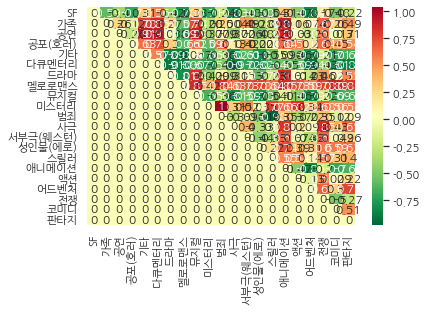

In [27]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

## 회고

본 프로젝트는 영화 시놉시스 코퍼스를 가지고 영화 구분과 영화 장르 간에 내재된 편향성을 측정하는 프로젝트입니다.

영화시놉시스를 Okt로 한글형태소 분석을 하고서,명사만을 추출하여, 단어토큰을 구성하고, 토큰화된 문장 전체의 크기는 71,156개였습니다.

Embedding model은 word2Vec model로 하고서, 토큰화된 영화시놉시스 문장을 모델에 입력하여 학습시켰습니다.
word2Vec model 문자 Sentence를 단어 토큰화해서, 정수 인덱싱없이 Sentence 상태로 입력할수 있어서,
편하고 train method가 있긴하나, 별도의 경우에 사용하며, 보통은 train 메소드없이 학습되어 사용하기가 편합니다.

모델은 시놉시스로 학습완료하고서, WEAT score를 구하기위한 준비로 Target 대표단어와 Attribute 대표단어를 구하기 위해서,
'synopsis_art.txt', 'synopsis_gen.txt' 로드하여, Okt로 분석후 명사만 취해서, 단어토큰화를 하고서, Tfidf로 벡터화를 시킨후에
예술장르와 일반 장르영화의 문장으로 중복을 제거한 이후에, vectorizer.get_feature_names() 를 이용해서, 단어화 시킨후, 100 단어씩 고른후
중복단어를 제거하고서, 총 15개 단어를 대표단어로 추출하였습니다.

다음단계로 전체 영화장르 21개를 대상으로 Okt로 장르별 단어토큰화를 한이후, Tfidf로 벡터화한후, 위에서의 과정을 거쳐, 21개 장르별로 
15개씩의 대표단어를 추출하였습니다.

추출한 단어로 weat_score(X, Y, A, B)함수를 통하여, 위에서 Target으로 선정한 예술장르와 일반장르를 X,Y로 놓고, Attribute로 삼기위해 21개 장르중 2개씩 짝을 맞추어서, A,B로 놓고서, 전체 영화장르에 대해 EWEAT score를 계산하였습니다.


WEAT score가 0.8 이상 8개, -0.8 이하의 경우 11개 총 19개만 해석해 보면 아래와 같습니다.


(1) 0.8 이상       
예술영화와 일반영화, 그리고 Attribute에 나와있는 21가지 장르중 대체로 공연영화가 여러 장르에서  예술영화와 가깝고 그외 멜로로맨스,가족영화,미스터리영화가 가까운 편이며, 애니메이션 영화, 기타영화, 코미디, 범죄, 뮤지컬영화등이 일반 영화와 가까운 것으로 Weat score 상 나타났습니다.

(2) -0.8이하       
예술영화와 일반영화, 그리고 Attribute에 나와있는 21가지 장르중 대체로 다큐영화가 여러 장르에서 예술영화와 거리가 멀고, 드라마,스릴러,어드벤쳐,멜로로맨스영화등이 일반 영화와 거리가 먼 것으로 나타났습니다.

(3) 검토 결론           

WEAT score가 사람들이 갖는 편향을 현재의 데이터로만 보면, 뚜렷하게 파악하지는 못해도, 보통 이상으로는 파악하는 것으로 보입니다.


#### (4)  개선사항 실행본은  아래 별도링크로 첨부 제출함   
그리고, 본 제출본을 진행하면서, Target 의 대표단어 추출시에 교재에 나온 100개가 아니고, 1000개로 늘려서 중복단어 제거후 15개씩 추출했을때, 영화장르카테고리와 어울리는 대표단어들이 나오길래, 이것을 확장해서, 전체 장르에 적용해 보기로 했습니다.
그래서,  이를 Attribute로 쓰는 전체 영화장르 21개를 대상으로 Tfidf한후에, 그것으로 21개장르에서 각각  1000개씩 뽑아서, 전체 21개 문장에 공통적으로 들어가는 중복단어를 제거하면, 대표단어들의 특징이 더 뚜렷해 질것을 예상하고서,전체 21개 장르 전체의 중복단어제거방법을 찾던중, for loop는 너무 시간이 많이 소요될 것 같아서, Tfidf를 다시 사용하여, 중복문장을 정리하기로 했습니다.
이렇게 Tfidf로 중복문장을 제거한후 각문장별 평균적으로 남은 200여개들씩 중에서, 15개씩을 대표단어로 선정하였습니다.

추출한 단어로 weat_score(X, Y, A, B)함수를 통하여, 위에서 Target으로 선정한 예술장르와 일반장르를 X,Y로 놓고, Attribute로 삼기위해 21개 장르중 2개씩 짝을 맞추어서, A,B로 놓고서, 전체 영화장르에 대해 EWEAT score를 계산하였는데, 결과에 뚜렷한 개선점이 않보여서,
보조 제출본으로, 아래 링크로 제출합니다.

**[TF-IDF 사용상의 문제점 및 개선방안 보조자료로 제출함- 깃허브 링크]:**  https://github.com/lkh-7/first-repository/blob/master/%5BGDeep%5D06_%5BWEAK_WordEmbeddingAssociationTest%5D_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%9E%84%EB%B2%A0%EB%94%A9%EB%82%B4_%ED%8E%B8%ED%96%A5%EC%84%B1_%EC%95%8C%EC%95%84%EB%B3%B4%EA%B8%B0_Project_TF-IDF%EB%A1%9C%EC%A4%91%EB%B3%B5%EC%A0%9C%EA%B1%B0%EB%B2%84%EC%A0%84.ipynb


#### 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준

1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.

워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다. 

2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.

타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.    

3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.

전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.